# HW07 — Кластеризация (датасеты 01, 02, 04)

Я делаю кластеризацию без истинных меток.
Для каждого датасета:
- загружаю и делаю простой EDA,
- делаю препроцессинг (масштабирование обязательно),
- сравниваю минимум 2 алгоритма (KMeans + DBSCAN или Agglomerative),
- считаю метрики silhouette / Davies-Bouldin / Calinski-Harabasz,
- делаю визуализацию PCA(2D) для лучшего решения,
- сохраняю артефакты в папку artifacts/.

Для одного датасета делаю проверку устойчивости KMeans (5 запусков).

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score

from sklearn.decomposition import PCA
import joblib

RANDOM_STATE = 42


## 1. Вспомогательные функции

Здесь я делаю:
- функцию, которая считает метрики кластеризации,
- функцию для PCA(2D) и графика.


In [4]:
def to_dense(X):
    """Если после препроцессинга получилось sparse, превращаю в dense (для PCA и метрик)."""
    return X.toarray() if hasattr(X, "toarray") else X

def clustering_metrics(X, labels, is_dbscan=False):
    """
    Считает silhouette / DB / CH.
    Для DBSCAN: шум = -1. Я считаю метрики только по non-noise точкам и явно пишу долю шума.
    """
    Xd = to_dense(X)
    labels = np.asarray(labels)

    out = {}
    if is_dbscan:
        noise_share = float((labels == -1).mean())
        out["noise_share"] = noise_share

        mask = labels != -1
        # если все точки шум или остался 1 кластер — метрики нельзя честно посчитать
        if mask.sum() < 5 or len(np.unique(labels[mask])) < 2:
            out["silhouette"] = None
            out["davies_bouldin"] = None
            out["calinski_harabasz"] = None
            return out

        X_use = Xd[mask]
        y_use = labels[mask]
    else:
        out["noise_share"] = 0.0
        # если 1 кластер — silhouette нельзя
        if len(np.unique(labels)) < 2:
            out["silhouette"] = None
            out["davies_bouldin"] = None
            out["calinski_harabasz"] = None
            return out

        X_use = Xd
        y_use = labels

    out["silhouette"] = float(silhouette_score(X_use, y_use))
    out["davies_bouldin"] = float(davies_bouldin_score(X_use, y_use))
    out["calinski_harabasz"] = float(calinski_harabasz_score(X_use, y_use))
    return out

def pca_scatter(X, labels, title, save_path):
    Xd = to_dense(X)
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X2 = pca.fit_transform(Xd)

    plt.figure(figsize=(6, 5))
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, s=12)
    plt.title(title)
    plt.xlabel("PCA-1")
    plt.ylabel("PCA-2")
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()


## 2. Словари для сохранения результатов

Я буду собирать:
- metrics_summary: метрики по датасетам и алгоритмам,
- best_configs: что я выбрала как лучшее и почему.


In [5]:
metrics_summary = {}
best_configs = {}


# 3. Dataset 01

## 3.1 Загрузка и первичный анализ

В датасете есть:
- sample_id (это идентификатор, не признак),
- признаки f01..f08 (числовые),
пропусков обычно нет, но я проверю.


In [12]:
df1 = pd.read_csv("data/S07-hw-dataset-01.csv")
df1.head()


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


In [13]:
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


In [14]:
df1.describe().T


,count,mean,std,min,25%,50%,75%,max
sample_id,12000.0,5999.500000,3464.245950,0.000000,2999.750000,5999.500000,8999.250000,11999.000000
f01,12000.0,-2.424716,11.014315,-19.912573,-9.472623,-6.869404,0.523841,24.403381
f02,12000.0,19.107804,60.790338,-92.892652,-40.282955,54.069335,70.280739,112.229523
f03,12000.0,-0.222063,0.500630,-1.590979,-0.125145,-0.031753,0.054980,0.512277
f04,12000.0,-8.284501,59.269838,-134.303679,-48.345007,16.211728,28.067178,75.088604
f05,12000.0,-0.190717,7.026435,-11.869169,-5.132473,0.444730,3.942368,13.717091
f06,12000.0,0.962972,14.794713,-20.521164,-8.807706,-6.134169,2.334426,41.452857
f07,12000.0,0.033724,59.541782,-215.098834,-39.900520,-0.578494,39.719821,213.381767
f08,12000.0,0.007638,0.607053,-2.633469,-0.401483,0.005306,0.410132,2.490745


In [15]:
df1.isna().mean().sort_values(ascending=False)


sample_id    0.0
f01          0.0
f02          0.0
f03          0.0
f04          0.0
f05          0.0
f06          0.0
f07          0.0
f08          0.0
dtype: float64

Я отделяю sample_id и делаю X (все столбцы кроме sample_id).


In [16]:
sample_id_1 = df1["sample_id"].copy()
X1_raw = df1.drop(columns=["sample_id"])
X1_raw.shape


(12000, 8)

## 3.2 Препроцессинг (масштабирование обязательно)

Для distance-based методов я обязательно делаю StandardScaler.
Категориальных признаков тут нет, поэтому просто масштабирую числовые.


In [17]:
preprocess_1 = Pipeline([
    ("scaler", StandardScaler())
])

X1 = preprocess_1.fit_transform(X1_raw)


## 3.3 Модели (Dataset 01)

Я сравниваю минимум 2 алгоритма:
- KMeans (обязательно): подбираю k и строю график silhouette vs k
- DBSCAN: подбираю eps (min_samples фиксирую простым значением)


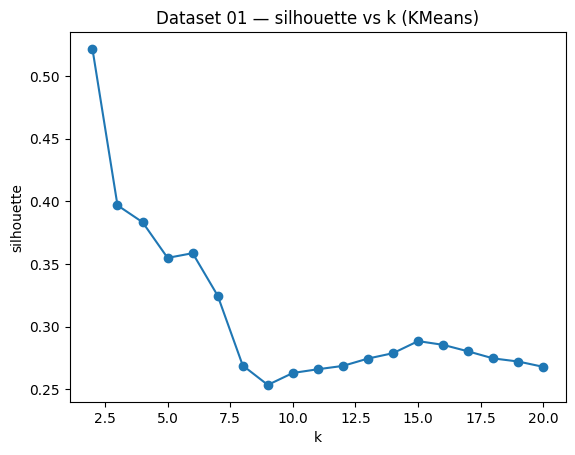

2

In [19]:
# --- KMeans: подбор k ---
k_values = list(range(2, 21))
sil_k = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X1)
    sil_k.append(silhouette_score(to_dense(X1), labels))

plt.figure()
plt.plot(k_values, sil_k, marker="o")
plt.title("Dataset 01 — silhouette vs k (KMeans)")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.savefig("artifacts/figures/ds1_silhouette_vs_k.png", dpi=150, bbox_inches="tight")
plt.show()

best_k_1 = k_values[int(np.argmax(sil_k))]
best_k_1


In [20]:
kmeans1 = KMeans(n_clusters=best_k_1, random_state=RANDOM_STATE, n_init=10)
labels_km_1 = kmeans1.fit_predict(X1)
m_km_1 = clustering_metrics(X1, labels_km_1, is_dbscan=False)
m_km_1


{'noise_share': 0.0,
 'silhouette': 0.5216395622404242,
 'davies_bouldin': 0.6853295219054459,
 'calinski_harabasz': 11786.95462267153}

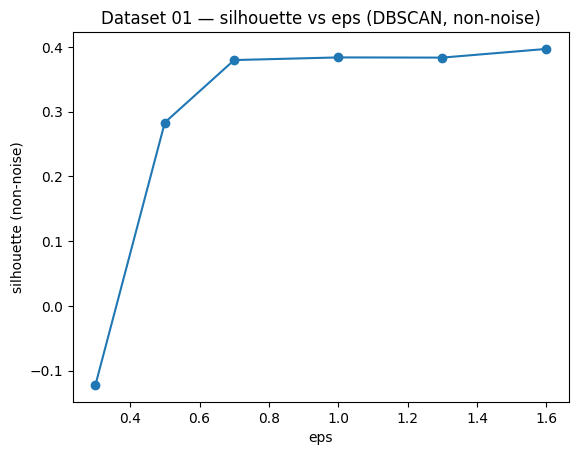

1.6

In [21]:
# --- DBSCAN: подбор eps ---
eps_values = [0.3, 0.5, 0.7, 1.0, 1.3, 1.6]
min_samples = 5

sil_eps = []
noise_eps = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X1)

    metrics = clustering_metrics(X1, labels, is_dbscan=True)
    sil_eps.append(-1 if metrics["silhouette"] is None else metrics["silhouette"])
    noise_eps.append(metrics["noise_share"])

plt.figure()
plt.plot(eps_values, sil_eps, marker="o")
plt.title("Dataset 01 — silhouette vs eps (DBSCAN, non-noise)")
plt.xlabel("eps")
plt.ylabel("silhouette (non-noise)")
plt.savefig("artifacts/figures/ds1_silhouette_vs_eps.png", dpi=150, bbox_inches="tight")
plt.show()

best_eps_1 = eps_values[int(np.argmax(sil_eps))]
best_eps_1


In [22]:
dbscan1 = DBSCAN(eps=best_eps_1, min_samples=min_samples)
labels_db_1 = dbscan1.fit_predict(X1)
m_db_1 = clustering_metrics(X1, labels_db_1, is_dbscan=True)
m_db_1


{'noise_share': 0.0,
 'silhouette': 0.3967888223601393,
 'davies_bouldin': 0.9644102343879997,
 'calinski_harabasz': 10446.597694416176}

## 3.4 Метрики и выбор лучшего решения (Dataset 01)

Я сохраняю метрики для KMeans и DBSCAN.
Лучшее решение выберу по silhouette (выше лучше), но также смотрю на долю шума и читаемость результата.


In [23]:
metrics_summary["dataset_01"] = {
    "KMeans": m_km_1,
    "DBSCAN": m_db_1
}

# выбираю лучшее по silhouette (если у DBSCAN silhouette None, он проигрывает)
sil_km = -1 if m_km_1["silhouette"] is None else m_km_1["silhouette"]
sil_db = -1 if m_db_1["silhouette"] is None else m_db_1["silhouette"]

if sil_km >= sil_db:
    best_configs["dataset_01"] = {"method": "KMeans", "params": {"k": int(best_k_1)}, "criterion": "silhouette"}
    best_labels_1 = labels_km_1
else:
    best_configs["dataset_01"] = {"method": "DBSCAN", "params": {"eps": float(best_eps_1), "min_samples": int(min_samples)}, "criterion": "silhouette (non-noise)"}
    best_labels_1 = labels_db_1

best_configs["dataset_01"]


{'method': 'KMeans', 'params': {'k': 2}, 'criterion': 'silhouette'}

## 3.5 PCA(2D) визуализация лучшего решения (Dataset 01)

Это обязательная визуализация.
Я сохраняю картинку в artifacts/figures/.


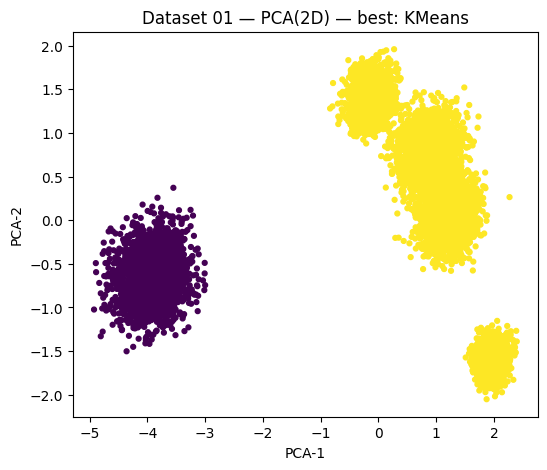

In [24]:
pca_scatter(
    X1, best_labels_1,
    title=f"Dataset 01 — PCA(2D) — best: {best_configs['dataset_01']['method']}",
    save_path="artifacts/figures/ds1_pca_best.png"
)


## 3.6 Проверка устойчивости (Dataset 01)

Я делаю 5 запусков KMeans с разными random_state и сравниваю разбиения через ARI.
Если ARI близко к 1, значит разбиение устойчивое.


In [25]:
k = best_k_1
seeds = [0, 1, 2, 3, 4]
labels_list = []

for s in seeds:
    km = KMeans(n_clusters=k, random_state=s, n_init=10)
    labels_list.append(km.fit_predict(X1))

# считаю средний ARI по всем парам
aris = []
for i in range(len(labels_list)):
    for j in range(i + 1, len(labels_list)):
        aris.append(adjusted_rand_score(labels_list[i], labels_list[j]))

np.mean(aris), np.min(aris), np.max(aris)


(np.float64(1.0), np.float64(1.0), np.float64(1.0))

Средний, минимальный и максимальный ARI равны 1.0.

Это означает, что при разных значениях `random_state`
кластеризация KMeans даёт одинаковые разбиения.
Следовательно, результат является полностью устойчивым.


## 3.7 Итог по датасету 01

- В этом датасете признаки в разных шкалах, поэтому я обязательно использовала StandardScaler.
- Я сравнила KMeans и DBSCAN.
- Лучший результат по silhouette показал KMeans: **0.522** (у DBSCAN **0.397**).
- По Davies-Bouldin (ниже лучше) тоже выиграл KMeans: **0.685** (у DBSCAN **0.964**).
- По Calinski-Harabasz (выше лучше) тоже лучше KMeans: **11786.95** (у DBSCAN **10446.60**).
- Поэтому я выбрала **KMeans с k=2** как лучшее решение для этого датасета.
- Проверка устойчивости KMeans дала ARI = 1.0 (средний, мин и макс), значит разбиение полностью стабильное.


# 4. Dataset 02

## 4.1 Загрузка и первичный анализ


In [26]:
df2 = pd.read_csv("data/S07-hw-dataset-02.csv")
df2.head()


,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


In [27]:
df2 = pd.read_csv("data/S07-hw-dataset-02.csv")
df2.head()


,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


In [58]:
df2.shape


(8000, 4)

Датасет небольшой по размеру, что также влияет на поведение алгоритмов кластеризации.


In [28]:
df2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


In [29]:
df2.describe().T


,count,mean,std,min,25%,50%,75%,max
sample_id,8000.0,3999.500000,2309.545410,0.000000,1999.750000,3999.500000,5999.250000,7999.000000
x1,8000.0,0.478867,0.955138,-2.487352,-0.116516,0.490658,1.085263,2.987555
x2,8000.0,0.241112,0.663195,-2.499237,-0.242357,0.241092,0.726526,2.995553
z_noise,8000.0,0.110454,8.097716,-34.056074,-5.392210,0.132470,5.655605,29.460076


In [30]:
df2.isna().mean().sort_values(ascending=False)


sample_id    0.0
x1           0.0
x2           0.0
z_noise      0.0
dtype: float64

## 4.2 Препроцессинг

Все признаки числовые. Я делаю StandardScaler.


In [33]:
sample_id_2 = df2["sample_id"].copy()
X2_raw = df2.drop(columns=["sample_id"])

preprocess_2 = Pipeline([
    ("scaler", StandardScaler())
])

X2 = preprocess_2.fit_transform(X2_raw)


## 4.3 Модели (KMeans + DBSCAN)

KMeans: подбираю k (2..20) и рисую silhouette vs k.
DBSCAN: подбираю eps и считаю долю шума.


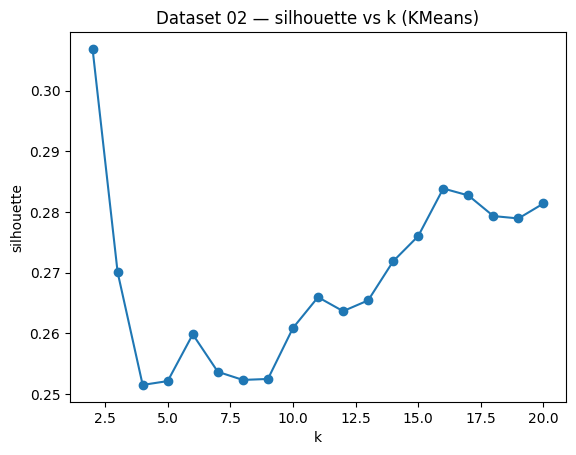

2

In [34]:
# KMeans подбор k
k_values = list(range(2, 21))
sil_k = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X2)
    sil_k.append(silhouette_score(to_dense(X2), labels))

plt.figure()
plt.plot(k_values, sil_k, marker="o")
plt.title("Dataset 02 — silhouette vs k (KMeans)")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.savefig("artifacts/figures/ds2_silhouette_vs_k.png", dpi=150, bbox_inches="tight")
plt.show()

best_k_2 = k_values[int(np.argmax(sil_k))]
best_k_2


In [35]:
kmeans2 = KMeans(n_clusters=best_k_2, random_state=RANDOM_STATE, n_init=10)
labels_km_2 = kmeans2.fit_predict(X2)
m_km_2 = clustering_metrics(X2, labels_km_2, is_dbscan=False)
m_km_2


{'noise_share': 0.0,
 'silhouette': 0.3068610017701601,
 'davies_bouldin': 1.3234721699867644,
 'calinski_harabasz': 3573.3933329348392}

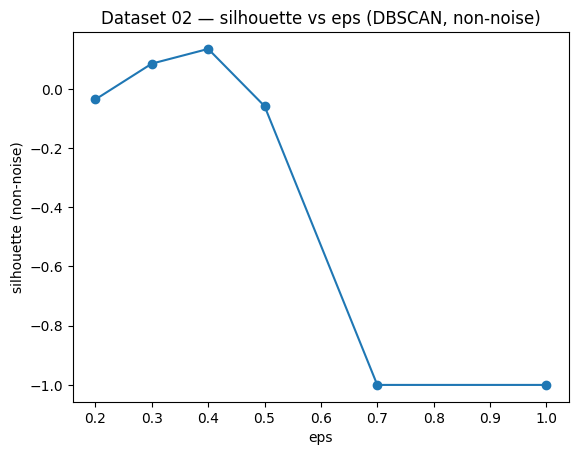

0.4

In [36]:
# DBSCAN подбор eps
eps_values = [0.2, 0.3, 0.4, 0.5, 0.7, 1.0]
min_samples = 5

sil_eps = []
for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X2)
    metrics = clustering_metrics(X2, labels, is_dbscan=True)
    sil_eps.append(-1 if metrics["silhouette"] is None else metrics["silhouette"])

plt.figure()
plt.plot(eps_values, sil_eps, marker="o")
plt.title("Dataset 02 — silhouette vs eps (DBSCAN, non-noise)")
plt.xlabel("eps")
plt.ylabel("silhouette (non-noise)")
plt.savefig("artifacts/figures/ds2_silhouette_vs_eps.png", dpi=150, bbox_inches="tight")
plt.show()

best_eps_2 = eps_values[int(np.argmax(sil_eps))]
best_eps_2


In [37]:
dbscan2 = DBSCAN(eps=best_eps_2, min_samples=min_samples)
labels_db_2 = dbscan2.fit_predict(X2)
m_db_2 = clustering_metrics(X2, labels_db_2, is_dbscan=True)
m_db_2


{'noise_share': 0.061875,
 'silhouette': 0.13486343378295018,
 'davies_bouldin': 0.6041569055438107,
 'calinski_harabasz': 31.396114775294762}

Для DBSCAN я отдельно учитываю шум: точки с меткой `-1`.

Долю шума я вывожу явно, а все метрики (silhouette, Davies-Bouldin и Calinski-Harabasz)
считаю только по точкам без шума (non-noise).


## 4.4 Метрики и выбор лучшего (Dataset 02)


In [38]:
metrics_summary["dataset_02"] = {
    "KMeans": m_km_2,
    "DBSCAN": m_db_2
}

sil_km = -1 if m_km_2["silhouette"] is None else m_km_2["silhouette"]
sil_db = -1 if m_db_2["silhouette"] is None else m_db_2["silhouette"]

if sil_km >= sil_db:
    best_configs["dataset_02"] = {"method": "KMeans", "params": {"k": int(best_k_2)}, "criterion": "silhouette"}
    best_labels_2 = labels_km_2
else:
    best_configs["dataset_02"] = {"method": "DBSCAN", "params": {"eps": float(best_eps_2), "min_samples": int(min_samples)}, "criterion": "silhouette (non-noise)"}
    best_labels_2 = labels_db_2

best_configs["dataset_02"]


{'method': 'KMeans', 'params': {'k': 2}, 'criterion': 'silhouette'}

## 4.5 PCA(2D) визуализация лучшего решения (Dataset 02)


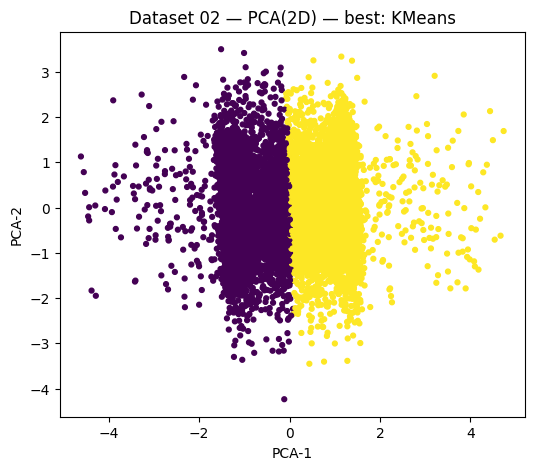

In [39]:
pca_scatter(
    X2, best_labels_2,
    title=f"Dataset 02 — PCA(2D) — best: {best_configs['dataset_02']['method']}",
    save_path="artifacts/figures/ds2_pca_best.png"
)


## 4.6 Итог по датасету 02

- В датасете есть шумовой признак `z_noise` и возможна нелинейная структура.
- Я сравнила KMeans и DBSCAN.
- По silhouette лучше оказался KMeans: **0.307** (у DBSCAN **0.135**, метрика считалась по non-noise точкам).
- DBSCAN выделил шум: доля шума примерно **0.062** (около 6.2% точек получили label = -1).
- Интересно, что по Davies-Bouldin DBSCAN выглядит лучше (**0.604** против **1.323**), но по моему основному критерию (silhouette) он проиграл.
- Поэтому итоговый выбор: **KMeans с k=2**.


В этой работе основным критерием выбора лучшего решения я использую silhouette.

Поэтому, несмотря на то что у DBSCAN ниже Davies-Bouldin,
итоговый выбор сделан в пользу KMeans,
так как у него выше silhouette.


# 5. Dataset 04

## 5.1 Загрузка и первичный анализ

В этом датасете есть:
- sample_id (не признак)
- 2 категориальных признака: cat_a, cat_b
- много числовых признаков n01..n30
- есть пропуски в числовых

Здесь обязательно нужен аккуратный препроцессинг.


In [40]:
df4 = pd.read_csv("data/S07-hw-dataset-04.csv")
df4.head()


,sample_id,cat_a,cat_b,n01,n02,n03,n04,n05,n06,n07,...,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30
0,0,B,X,-4.827501,-24.507466,-7.852963,0.771781,28.297884,-4.493911,-42.769449,...,24.597176,-26.354320,4.543397,-19.549036,-3.051332,-5.538587,-3.084457,5.499629,-6.128896,3.132067
1,1,F,V,51.302500,NaN,5.534737,51.305464,-8.027553,28.297548,NaN,...,-18.216260,8.527932,17.202115,-30.452260,0.855326,1.199066,3.597555,-2.239703,2.932710,0.473145
2,2,A,W,-4.820828,-2.625385,27.891578,1.523041,-5.776687,-16.298523,2.462937,...,-48.260775,9.313232,12.323411,55.081325,-3.945606,-0.280540,-0.130583,-7.353205,-2.942836,1.460477
3,3,B,X,-2.627573,-25.063639,-9.450011,-8.344669,22.371118,-11.525848,-43.762607,...,24.700663,-25.466915,-3.398665,-18.174541,0.438229,3.152556,3.859283,-2.678769,-2.213923,-4.724639
4,4,C,Y,-11.415710,-8.692169,48.636163,14.661826,-39.634618,10.769075,40.187536,...,-79.710383,-13.694253,41.575892,-9.498640,1.529608,-1.641347,3.500090,3.111257,1.475232,-1.321676


In [41]:
df4.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  10000 non-null  int64  
 1   cat_a      10000 non-null  object 
 2   cat_b      10000 non-null  object 
 3   n01        9826 non-null   float64
 4   n02        9811 non-null   float64
 5   n03        9801 non-null   float64
 6   n04        9808 non-null   float64
 7   n05        9799 non-null   float64
 8   n06        9817 non-null   float64
 9   n07        9796 non-null   float64
 10  n08        9806 non-null   float64
 11  n09        9805 non-null   float64
 12  n10        9811 non-null   float64
 13  n11        9796 non-null   float64
 14  n12        9798 non-null   float64
 15  n13        9803 non-null   float64
 16  n14        9802 non-null   float64
 17  n15        9814 non-null   float64
 18  n16        9809 non-null   float64
 19  n17        9788 non-null   float64
 20  n18    

In [42]:
df4.isna().mean().sort_values(ascending=False).head(15)


n26    0.0224
n21    0.0215
n18    0.0212
n17    0.0212
n28    0.0211
n24    0.0207
n11    0.0204
n07    0.0204
n20    0.0203
n12    0.0202
n29    0.0202
n05    0.0201
n03    0.0199
n14    0.0198
n13    0.0197
dtype: float64

Я отделяю sample_id и делаю X.


In [43]:
sample_id_4 = df4["sample_id"].copy()
X4_raw = df4.drop(columns=["sample_id"])
X4_raw.shape


(10000, 32)

## 5.2 Препроцессинг (обязательно)

- Числовые: заполняю пропуски средним (SimpleImputer) + StandardScaler
- Категориальные: заполняю пропуски самым частым + OneHotEncoder

Одинаково применяю этот препроцессинг ко всем моделям датасета 04.


In [45]:
cat_cols = ["cat_a", "cat_b"]
num_cols = [c for c in X4_raw.columns if c not in cat_cols]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_4 = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

X4 = preprocess_4.fit_transform(X4_raw)


## 5.3 Модели (Dataset 04)

Я сравниваю минимум 2 алгоритма:
- KMeans (обязательно): подбираю k
- AgglomerativeClustering: подбираю k и пробую 2 linkage (ward и average)

Для Agglomerative я работаю с уже подготовленными признаками.


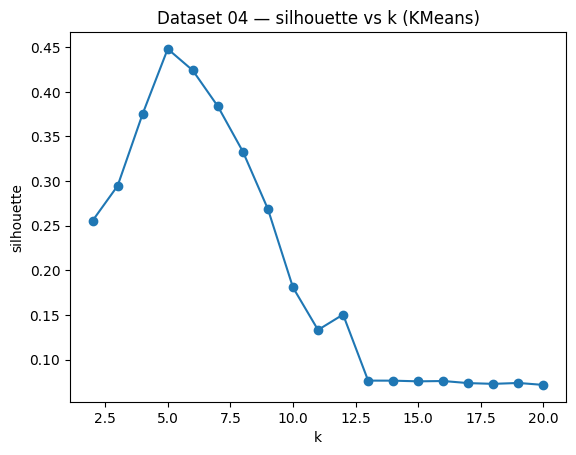

5

In [46]:
# KMeans подбор k
k_values = list(range(2, 21))
sil_k = []

X4d = to_dense(X4)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X4d)
    sil_k.append(silhouette_score(X4d, labels))

plt.figure()
plt.plot(k_values, sil_k, marker="o")
plt.title("Dataset 04 — silhouette vs k (KMeans)")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.savefig("artifacts/figures/ds4_silhouette_vs_k.png", dpi=150, bbox_inches="tight")
plt.show()

best_k_4 = k_values[int(np.argmax(sil_k))]
best_k_4


In [47]:
kmeans4 = KMeans(n_clusters=best_k_4, random_state=RANDOM_STATE, n_init=10)
labels_km_4 = kmeans4.fit_predict(X4d)
m_km_4 = clustering_metrics(X4d, labels_km_4, is_dbscan=False)
m_km_4


{'noise_share': 0.0,
 'silhouette': 0.4480173757704073,
 'davies_bouldin': 0.9756940955278773,
 'calinski_harabasz': 5103.099776986092}

In [48]:
# Agglomerative: сравню два linkage
agg_results = []

for linkage in ["ward", "average"]:
    # ward требует евклидово расстояние и обычно работает на dense, у нас dense уже есть
    agg = AgglomerativeClustering(n_clusters=best_k_4, linkage=linkage)
    labels = agg.fit_predict(X4d)
    metrics = clustering_metrics(X4d, labels, is_dbscan=False)
    agg_results.append((linkage, labels, metrics))

agg_results


[('ward',
  array([4, 0, 1, ..., 3, 2, 2], shape=(10000,)),
  {'noise_share': 0.0,
   'silhouette': 0.4480173757704073,
   'davies_bouldin': 0.9756940955278773,
   'calinski_harabasz': 5103.099776986092}),
 ('average',
  array([4, 0, 1, ..., 2, 3, 3], shape=(10000,)),
  {'noise_share': 0.0,
   'silhouette': 0.4480173757704073,
   'davies_bouldin': 0.9756940955278773,
   'calinski_harabasz': 5103.099776986093})]

## 5.4 Метрики и выбор лучшего (Dataset 04)

Я сравниваю KMeans и Agglomerative и выбираю лучшее решение.


In [49]:
# беру метрики агломеративных
m_agg_ward = agg_results[0][2] if agg_results[0][0] == "ward" else agg_results[1][2]
m_agg_avg  = agg_results[0][2] if agg_results[0][0] == "average" else agg_results[1][2]

metrics_summary["dataset_04"] = {
    "KMeans": m_km_4,
    "Agglomerative_ward": m_agg_ward,
    "Agglomerative_average": m_agg_avg
}

# выберу лучший вариант по silhouette
candidates = [
    ("KMeans", labels_km_4, m_km_4, {"k": int(best_k_4)}),
    ("Agglomerative_ward", agg_results[0][1] if agg_results[0][0]=="ward" else agg_results[1][1], m_agg_ward, {"k": int(best_k_4), "linkage": "ward"}),
    ("Agglomerative_average", agg_results[0][1] if agg_results[0][0]=="average" else agg_results[1][1], m_agg_avg, {"k": int(best_k_4), "linkage": "average"}),
]

best = None
best_sil = -1

for name, labels, met, params in candidates:
    sil = -1 if met["silhouette"] is None else met["silhouette"]
    if sil > best_sil:
        best_sil = sil
        best = (name, labels, met, params)

best_name_4, best_labels_4, best_met_4, best_params_4 = best

best_configs["dataset_04"] = {"method": best_name_4, "params": best_params_4, "criterion": "silhouette"}
best_configs["dataset_04"]


{'method': 'KMeans', 'params': {'k': 5}, 'criterion': 'silhouette'}

## 5.5 PCA(2D) визуализация лучшего решения (Dataset 04)


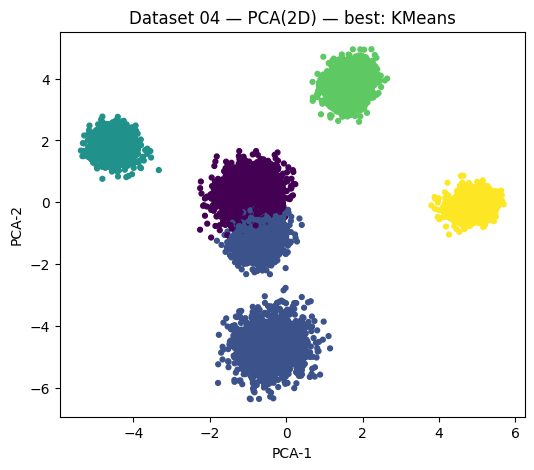

In [50]:
pca_scatter(
    X4d, best_labels_4,
    title=f"Dataset 04 — PCA(2D) — best: {best_configs['dataset_04']['method']}",
    save_path="artifacts/figures/ds4_pca_best.png"
)


## 5.6 Итог по датасету 04

- В этом датасете есть пропуски в числовых признаках и есть категориальные признаки `cat_a` и `cat_b`.
- Поэтому я сделала препроцессинг:
  - числовые: заполнение пропусков средним + StandardScaler,
  - категориальные: заполнение пропусков самым частым + OneHotEncoder.
- Я сравнила KMeans и AgglomerativeClustering (ward и average).
- Метрики у всех вариантов получились одинаковыми:
  - silhouette = **0.448**
  - Davies-Bouldin = **0.976**
  - Calinski-Harabasz = **5103.10**
- Поэтому я выбрала самый простой вариант: **KMeans с k=5**.


# 6. Артефакты

Я сохраняю:
- metrics_summary.json
- best_configs.json
- labels CSV для лучшего решения каждого датасета (sample_id, cluster_label)


In [51]:
# 6.1 json с метриками
with open("artifacts/metrics_summary.json", "w", encoding="utf-8") as f:
    json.dump(metrics_summary, f, ensure_ascii=False, indent=2)

# 6.2 json с лучшими настройками
with open("artifacts/best_configs.json", "w", encoding="utf-8") as f:
    json.dump(best_configs, f, ensure_ascii=False, indent=2)

print("Saved: artifacts/metrics_summary.json and artifacts/best_configs.json")


Saved: artifacts/metrics_summary.json and artifacts/best_configs.json


In [53]:
# 6.3 labels CSV для каждого датасета (формат: sample_id, cluster_label)
labels1 = pd.DataFrame({"sample_id": sample_id_1, "cluster_label": best_labels_1})
labels2 = pd.DataFrame({"sample_id": sample_id_2, "cluster_label": best_labels_2})
labels4 = pd.DataFrame({"sample_id": sample_id_4, "cluster_label": best_labels_4})

labels1.to_csv("artifacts/labels/labels_hw07_ds1.csv", index=False)
labels2.to_csv("artifacts/labels/labels_hw07_ds2.csv", index=False)
labels4.to_csv("artifacts/labels/labels_hw07_ds4.csv", index=False)

print("Saved labels CSV in artifacts/labels/")


Saved labels CSV in artifacts/labels/
